In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import inspect

summer_concentrations = np.array([0.037, 0.034, 0.018, 0.042, 0.049, 0.022, 0.014, 
0.016, 0.016, 0.048, 0.008, 0.012, 0.034, 0.064, 0.019, 0.043, 0.038, 0.042, 0.048, 0.053, 0.031, 0.030])
up_summer = np.array([0.037, 0.034, 0.018, 0.014, 0.016, 0.016, 0.034, 0.064, 0.019, 0.048, 0.053])
down_summer = np.array([0.042, 0.049, 0.022, 0.048, 0.008, 0.012, 0.043, 0.038, 0.042, 0.031, 0.030])

spring_concentrations = np.array([0.022, 0.028, 0.046, 0.033, 0.024, 0.048, 0.058, 0.038, 0.048, 0.011, 0.031]) 
up_spring = np.array([0.022, 0.028, 0.048, 0.058, 0.038])
down_spring = np.array([0.046, 0.033, 0.024, 0.048, 0.011, 0.031])

Functions

In [2]:
def significant_average(data, hypothesized_mean=0, pvalue=0.05):
    """
    Analyzes carbon concentrations and returns a DataFrame with average, t-statistic, p-value, and significance.

    Parameters:
    data (array-like): Array of concentration values.
    hypothesized_mean (float): Hypothesized mean for the t-test. Default is 0.

    Returns:
    pd.DataFrame: DataFrame with columns 'data_name', 'average', 't_stat', 'p_value', and 'significant'.
    """
    # calculate the mean
    mean_concentration = np.mean(data)
    # perform a one-sample t-test
    t_stat, p_value = stats.ttest_1samp(data, hypothesized_mean)
    # determine if the result is significant
    significant = 'Yes' if p_value < pvalue else 'No'
    # get the variable name of the data
    frame = inspect.currentframe().f_back
    data_name = [name for name, value in frame.f_locals.items() if value is data][0]
    # create a DataFrame
    df = pd.DataFrame({
        'data_name': [data_name],
        'average': [mean_concentration],
        't_stat': [t_stat],
        'p_value': [p_value],
        'significant': [significant]
    })
    return df

def significant_median(data, hypothesized_median=0, pvalue=0.05):
    """
    Analyzes carbon concentrations and returns a DataFrame with median, z-statistic, p-value, and significance.
    
    Parameters:
    data (array-like): Array of concentration values.
    hypothesized_median (float): Hypothesized median for the Wilcoxon test. Default is 0.
    
    Returns:
    pd.DataFrame: DataFrame with columns 'data_name', 'median', 'z_stat', 'p_value', and 'significant'.
    """
    # calculate the median
    median_concentration = np.median(data)
    # perform a one-sample Wilcoxon signed-rank test
    z_stat, p_value = stats.wilcoxon(data - hypothesized_median)
    # determine if the result is significant
    significant = 'Yes' if p_value < pvalue else 'No'
    # get the variable name of the data
    frame = inspect.currentframe().f_back
    data_name = [name for name, value in frame.f_locals.items() if value is data][0]
    # create a DataFrame
    df = pd.DataFrame({
        'data_name': [data_name],
        'median': [median_concentration],
        'z_stat': [z_stat],
        'p_value': [p_value],
        'significant': [significant]
    })
    return df

# Generate the empirical CDF from the already existing data (only for plotting purposes)
def smooth_cdf(data, num_points=1000):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Interpolate the CDF
    interpolation = interp1d(sorted_data, cdf, kind='linear', bounds_error=False, fill_value=(0, 1))
    
    # Generate a smooth CDF by interpolating between the smallest and largest values
    x_values = np.linspace(sorted_data.min(), sorted_data.max(), num_points)
    y_values = interpolation(x_values)
    
    return x_values, y_values

In [3]:
# calculations
summer = significant_average(summer_concentrations, hypothesized_mean=0.035) # comparing to spring average
spring = significant_average(spring_concentrations, hypothesized_mean=0.033) # comparing to summer average
summer_upstream = significant_average(up_summer, hypothesized_mean=0.039)
summer_downstream = significant_average(down_summer, hypothesized_mean=0.032)
spring_upstream = significant_average(up_spring, hypothesized_mean=0.032)
spring_downstream = significant_average(down_spring, hypothesized_mean=0.033)
# concatenate all dataframes together
averages = pd.concat([summer, spring, summer_upstream, summer_downstream, spring_upstream, spring_downstream])
averages.set_index('data_name', inplace=True)

# calculate medians
summer = significant_median(summer_concentrations, hypothesized_median=0.033) # comparing to spring median
spring = significant_median(spring_concentrations, hypothesized_median=0.034) # comparing to summer median
summer_upstream = significant_median(up_summer, hypothesized_median=0.038)
summer_downstream = significant_median(down_summer, hypothesized_median=0.032)
spring_upstream = significant_median(up_spring, hypothesized_median=0.034)
spring_downstream = significant_median(down_spring, hypothesized_median=0.038)
# concatenate all dataframes together
medians = pd.concat([summer, spring, summer_upstream, summer_downstream, spring_upstream, spring_downstream])
medians.set_index('data_name', inplace=True)


### Carbon PDFs


Full reach spring vs summer

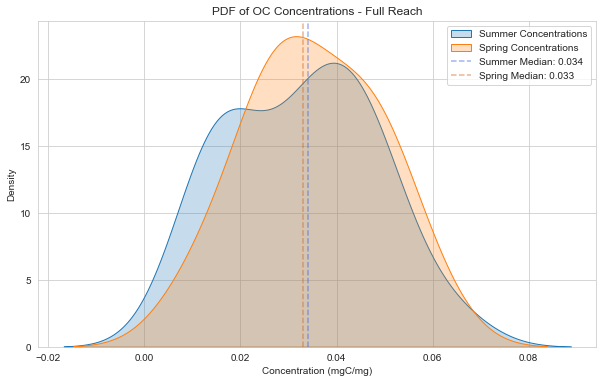

In [5]:
# plotting the PDFs
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.kdeplot(summer_concentrations, label='Summer Concentrations', fill=True)
sns.kdeplot(spring_concentrations, label='Spring Concentrations', fill=True)

# draw vertical lines at the medians
plt.axvline(medians.loc['summer_concentrations', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['summer_concentrations', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['spring_concentrations', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['spring_concentrations', 'median']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Full Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs.png', dpi=300)
plt.show()

Upstream spring vs summer

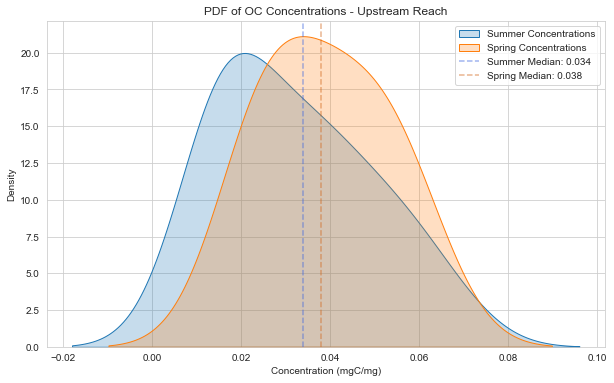

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(up_summer, label='Summer Concentrations', fill=True)
sns.kdeplot(up_spring, label='Spring Concentrations', fill=True)

# draw vertical lines at the means
plt.axvline(medians.loc['up_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['up_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['up_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['up_spring', 'median']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Upstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs_upstream.png', dpi=300)
plt.show()

Downstream spring vs summer

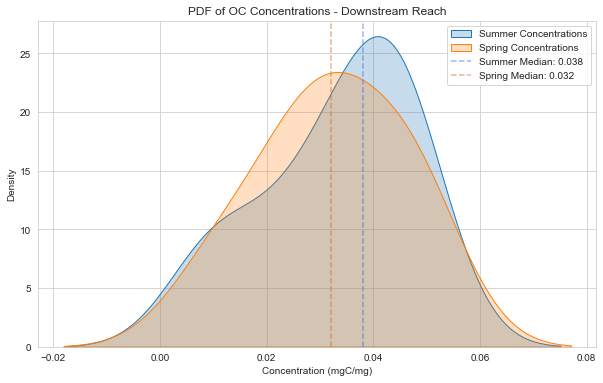

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(down_summer, label='Summer Concentrations', fill=True)
sns.kdeplot(down_spring, label='Spring Concentrations', fill=True)

# draw vertical lines at the means
plt.axvline(medians.loc['down_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['down_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['down_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['down_spring', 'median']:.3f}", alpha=0.5)

plt.title('PDF of OC Concentrations - Downstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Density')
plt.legend()
plt.savefig('plots/seasonal_carbon_PDFs_downstream.png', dpi=300)
plt.show()

### Carbon CDFs

Full reach spring vs summer

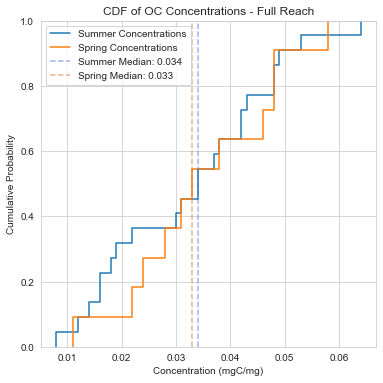

In [25]:
plt.figure(figsize=(6, 6))

# Plot the empirical CDFs
sns.ecdfplot(summer_concentrations, label='Summer Concentrations')
sns.ecdfplot(spring_concentrations, label='Spring Concentrations')

# draw vertical lines at the medians
plt.axvline(medians.loc['summer_concentrations', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['summer_concentrations', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['spring_concentrations', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['spring_concentrations', 'median']:.3f}", alpha=0.5)

plt.title('CDF of OC Concentrations - Full Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs.png', dpi=300)
plt.show()

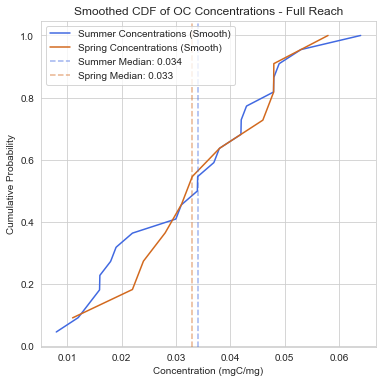

In [24]:
# plot smooth CDFs for both datasets
plt.figure(figsize=(6, 6))

x_summer, y_summer = smooth_cdf(summer_concentrations)
x_spring, y_spring = smooth_cdf(spring_concentrations)

plt.plot(x_summer, y_summer, label='Summer Concentrations (Smooth)', color='royalblue')
plt.plot(x_spring, y_spring, label='Spring Concentrations (Smooth)', color='chocolate')

# draw vertical lines at the medians
plt.axvline(medians.loc['summer_concentrations', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['summer_concentrations', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['spring_concentrations', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['spring_concentrations', 'median']:.3f}", alpha=0.5)

plt.title('Smoothed CDF of OC Concentrations - Full Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs_smooth.png', dpi=300)
plt.show()

Upstream spring vs summer

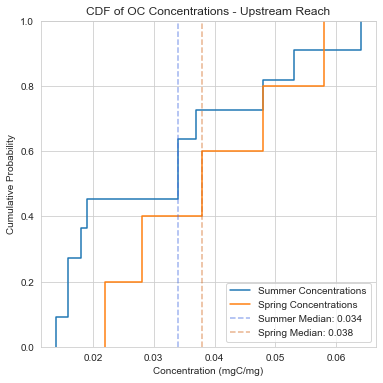

In [27]:
plt.figure(figsize=(6, 6))

# plot the empirical CDFs
sns.ecdfplot(up_summer, label='Summer Concentrations')
sns.ecdfplot(up_spring, label='Spring Concentrations')

# draw vertical lines at the medians
plt.axvline(medians.loc['up_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['up_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['up_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['up_spring', 'median']:.3f}", alpha=0.5)

plt.title('CDF of OC Concentrations - Upstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs_upstream.png', dpi=300)
plt.show()

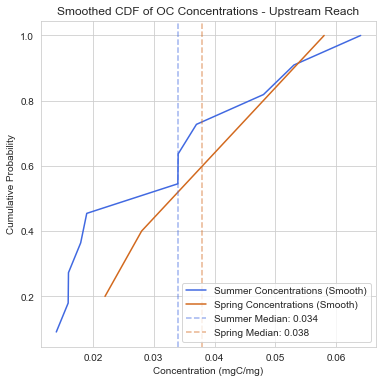

In [28]:
# plot smooth CDFs for both datasets
plt.figure(figsize=(6, 6))

x_summer, y_summer = smooth_cdf(up_summer)
x_spring, y_spring = smooth_cdf(up_spring)

plt.plot(x_summer, y_summer, label='Summer Concentrations (Smooth)', color='royalblue')
plt.plot(x_spring, y_spring, label='Spring Concentrations (Smooth)', color='chocolate')

# draw vertical lines at the medians
plt.axvline(medians.loc['up_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['up_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['up_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['up_spring', 'median']:.3f}", alpha=0.5)

plt.title('Smoothed CDF of OC Concentrations - Upstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs_upstream_smooth.png', dpi=300)
plt.show()

Downstream spring vs summer

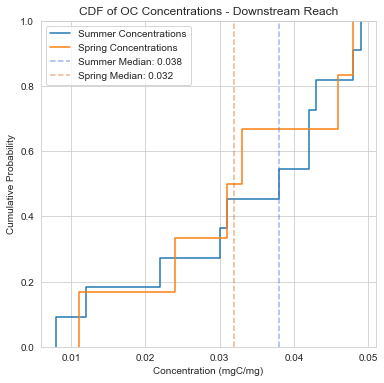

In [16]:
plt.figure(figsize=(6, 6))

# plot the empirical CDFs
sns.ecdfplot(down_summer, label='Summer Concentrations')
sns.ecdfplot(down_spring, label='Spring Concentrations')

# draw vertical lines at the medians
plt.axvline(medians.loc['down_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['down_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['down_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['down_spring', 'median']:.3f}", alpha=0.5)

plt.title('CDF of OC Concentrations - Downstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs_downstream.png', dpi=300)
plt.show()


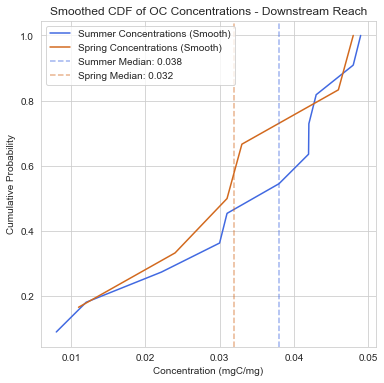

In [21]:
# plot smooth CDFs for both datasets
plt.figure(figsize=(6, 6))

x_summer, y_summer = smooth_cdf(down_summer)
x_spring, y_spring = smooth_cdf(down_spring)

plt.plot(x_summer, y_summer, label='Summer Concentrations (Smooth)', color='royalblue')
plt.plot(x_spring, y_spring, label='Spring Concentrations (Smooth)', color='chocolate')

# draw vertical lines at the medians
plt.axvline(medians.loc['down_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['down_summer', 'median']:.3f}", alpha=0.5)
plt.axvline(medians.loc['down_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['down_spring', 'median']:.3f}", alpha=0.5)

plt.title('Smoothed CDF of OC Concentrations - Downstream Reach')
plt.xlabel('Concentration (mgC/mg)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.savefig('plots/seasonal_carbon_CDFs_downstream_smooth.png', dpi=300)
plt.show()

### Combined Plots

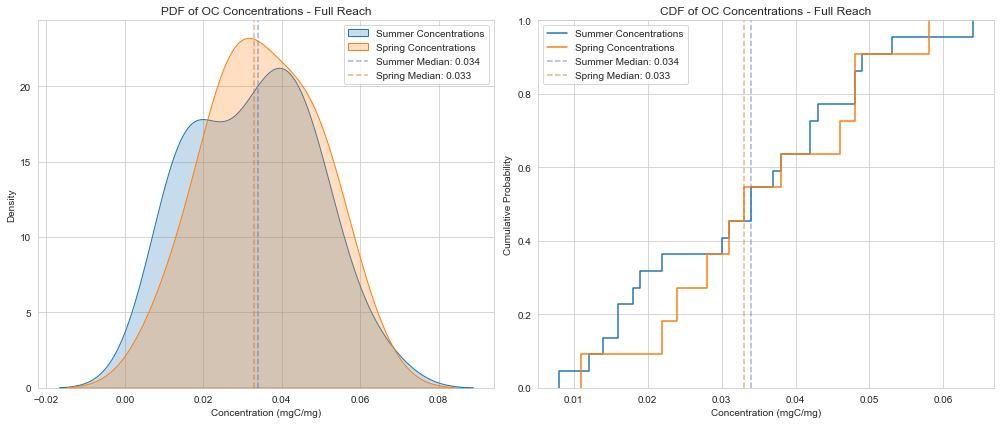

In [29]:
sns.set_style('whitegrid')

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PDF on the first subplot
sns.kdeplot(summer_concentrations, label='Summer Concentrations', fill=True, ax=ax[0])
sns.kdeplot(spring_concentrations, label='Spring Concentrations', fill=True, ax=ax[0])

# Draw vertical lines at the medians (PDF)
ax[0].axvline(medians.loc['summer_concentrations', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['summer_concentrations', 'median']:.3f}", alpha=0.5)
ax[0].axvline(medians.loc['spring_concentrations', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['spring_concentrations', 'median']:.3f}", alpha=0.5)

# PDF subplot details
ax[0].set_title('PDF of OC Concentrations - Full Reach')
ax[0].set_xlabel('Concentration (mgC/mg)')
ax[0].set_ylabel('Density')
ax[0].legend()

# Plot CDF on the second subplot
sns.ecdfplot(summer_concentrations, label='Summer Concentrations', ax=ax[1])
sns.ecdfplot(spring_concentrations, label='Spring Concentrations', ax=ax[1])

# Draw vertical lines at the medians (CDF)
ax[1].axvline(medians.loc['summer_concentrations', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['summer_concentrations', 'median']:.3f}", alpha=0.5)
ax[1].axvline(medians.loc['spring_concentrations', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['spring_concentrations', 'median']:.3f}", alpha=0.5)

# CDF subplot details
ax[1].set_title('CDF of OC Concentrations - Full Reach')
ax[1].set_xlabel('Concentration (mgC/mg)')
ax[1].set_ylabel('Cumulative Probability')
ax[1].legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('plots/seasonal_carbon_PDF_CDF_subplot.png', dpi=300)
plt.show()


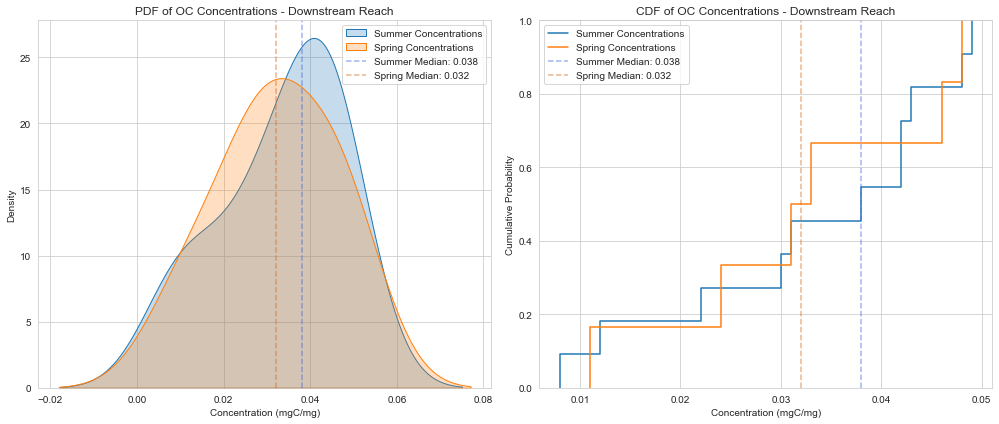

In [31]:
sns.set_style('whitegrid')

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PDF on the first subplot
sns.kdeplot(down_summer, label='Summer Concentrations', fill=True, ax=ax[0])
sns.kdeplot(down_spring, label='Spring Concentrations', fill=True, ax=ax[0])

# draw vertical lines at the medians
ax[0].axvline(medians.loc['down_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['down_summer', 'median']:.3f}", alpha=0.5)
ax[0].axvline(medians.loc['down_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['down_spring', 'median']:.3f}", alpha=0.5)

# PDF subplot details
ax[0].set_title('PDF of OC Concentrations - Downstream Reach')
ax[0].set_xlabel('Concentration (mgC/mg)')
ax[0].set_ylabel('Density')
ax[0].legend()

# Plot CDF on the second subplot
sns.ecdfplot(down_summer, label='Summer Concentrations', ax=ax[1])
sns.ecdfplot(down_spring, label='Spring Concentrations', ax=ax[1])

# draw vertical lines at the medians
ax[1].axvline(medians.loc['down_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['down_summer', 'median']:.3f}", alpha=0.5)
ax[1].axvline(medians.loc['down_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['down_spring', 'median']:.3f}", alpha=0.5)

# CDF subplot details
ax[1].set_title('CDF of OC Concentrations - Downstream Reach')
ax[1].set_xlabel('Concentration (mgC/mg)')
ax[1].set_ylabel('Cumulative Probability')
ax[1].legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('plots/seasonal_carbon_PDF_CDF_subplot_downstream.png', dpi=300)
plt.show()


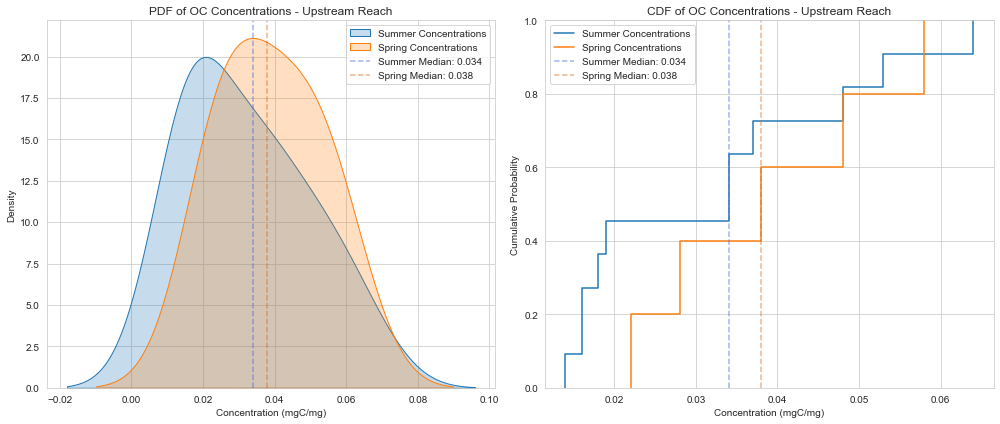

In [32]:
sns.set_style('whitegrid')

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PDF on the first subplot
sns.kdeplot(up_summer, label='Summer Concentrations', fill=True, ax=ax[0])
sns.kdeplot(up_spring, label='Spring Concentrations', fill=True, ax=ax[0])

# draw vertical lines at the medians
ax[0].axvline(medians.loc['up_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['up_summer', 'median']:.3f}", alpha=0.5)
ax[0].axvline(medians.loc['up_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['up_spring', 'median']:.3f}", alpha=0.5)

# PDF subplot details
ax[0].set_title('PDF of OC Concentrations - Upstream Reach')
ax[0].set_xlabel('Concentration (mgC/mg)')
ax[0].set_ylabel('Density')
ax[0].legend()

# Plot CDF on the second subplot
sns.ecdfplot(up_summer, label='Summer Concentrations', ax=ax[1])
sns.ecdfplot(up_spring, label='Spring Concentrations', ax=ax[1])

# draw vertical lines at the medians
ax[1].axvline(medians.loc['up_summer', 'median'], color='royalblue', linestyle='--', 
            label=f"Summer Median: {medians.loc['up_summer', 'median']:.3f}", alpha=0.5)
ax[1].axvline(medians.loc['up_spring', 'median'], color='chocolate', linestyle='--', 
            label=f"Spring Median: {medians.loc['up_spring', 'median']:.3f}", alpha=0.5)

# CDF subplot details
ax[1].set_title('CDF of OC Concentrations - Upstream Reach')
ax[1].set_xlabel('Concentration (mgC/mg)')
ax[1].set_ylabel('Cumulative Probability')
ax[1].legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('plots/seasonal_carbon_PDF_CDF_subplot_upstream.png', dpi=300)
plt.show()

### Histograms

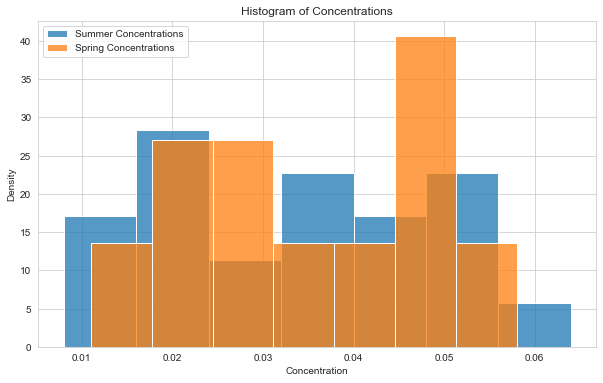

In [67]:
# Plot histogram
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(summer_concentrations, bins=7, stat='density', label='Summer Concentrations', fill=True)
sns.histplot(spring_concentrations, bins=7, stat='density', label='Spring Concentrations', fill=True)
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

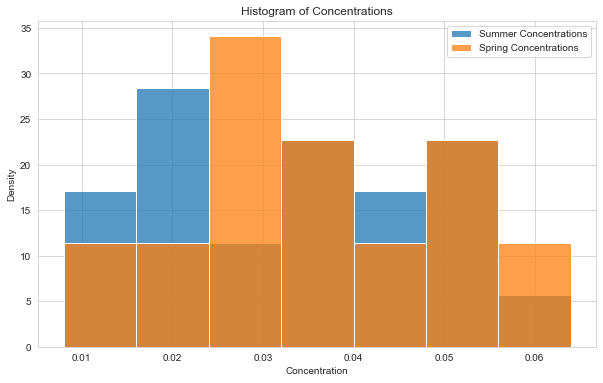

In [76]:
# Calculate the bin edges
min_concentration = min(summer_concentrations.min(), spring_concentrations.min())
max_concentration = max(summer_concentrations.max(), spring_concentrations.max())
bins = np.linspace(min_concentration, max_concentration, 8)  # 7 bins means 8 edges

# Plot histogram
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.histplot(summer_concentrations, bins=bins, stat='density', label='Summer Concentrations', fill=True)
sns.histplot(spring_concentrations, bins=bins, stat='density', label='Spring Concentrations', fill=True)
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

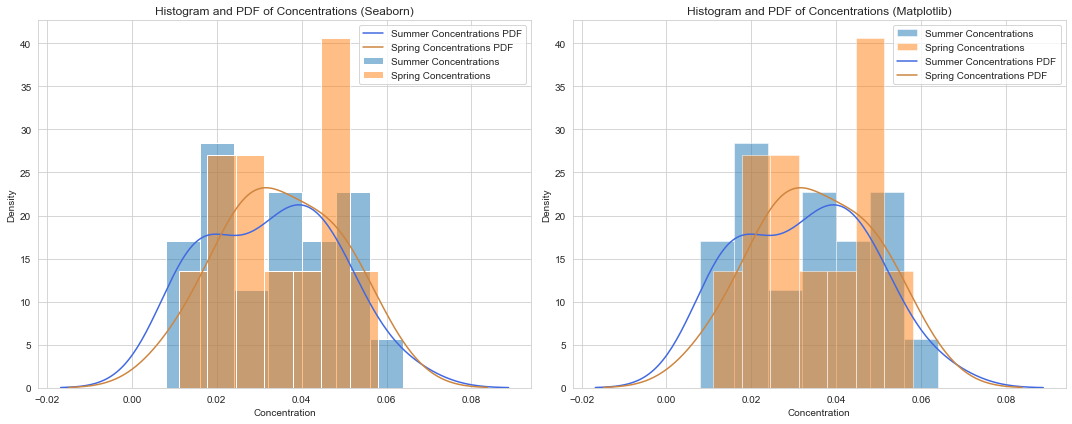

In [68]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram and PDF using sns.histplot and sns.kdeplot
sns.set_style('whitegrid')
sns.histplot(summer_concentrations, bins=7, stat='density', label='Summer Concentrations', fill=True, alpha=0.5, ax=axes[0])
sns.histplot(spring_concentrations, bins=7, stat='density', label='Spring Concentrations', fill=True, alpha=0.5, ax=axes[0])
sns.kdeplot(summer_concentrations, label='Summer Concentrations PDF', fill=False, color='royalblue', ax=axes[0])
sns.kdeplot(spring_concentrations, label='Spring Concentrations PDF', fill=False, color='peru', ax=axes[0])
axes[0].set_title('Histogram and PDF of Concentrations (Seaborn)')
axes[0].set_xlabel('Concentration')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot histogram and PDF using plt.hist and plt.plot
axes[1].hist(summer_concentrations, bins=7, density=True, alpha=0.5, label='Summer Concentrations')
axes[1].hist(spring_concentrations, bins=7, density=True, alpha=0.5, label='Spring Concentrations')
sns.kdeplot(summer_concentrations, label='Summer Concentrations PDF', fill=False, color='royalblue', ax=axes[1])
sns.kdeplot(spring_concentrations, label='Spring Concentrations PDF', fill=False, color='peru', ax=axes[1])
axes[1].set_title('Histogram and PDF of Concentrations (Matplotlib)')
axes[1].set_xlabel('Concentration')
axes[1].set_ylabel('Density')
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

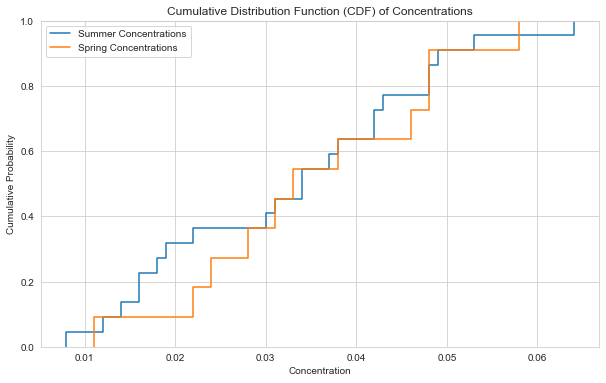

In [69]:
# Plotting the CDFs
plt.figure(figsize=(10, 6))
sns.ecdfplot(summer_concentrations, label='Summer Concentrations')
sns.ecdfplot(spring_concentrations, label='Spring Concentrations')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## Hecho a mano

In [70]:
# Calculate PDF for summer concentrations
hist_summer, bins_summer = np.histogram(summer_concentrations, bins=10000, density=True)
pdf_summer = hist_summer / sum(hist_summer)
# Calculate PDF for spring concentrations
hist_spring, bins_spring = np.histogram(spring_concentrations, bins=10000, density=True)
pdf_spring = hist_spring / sum(hist_spring)

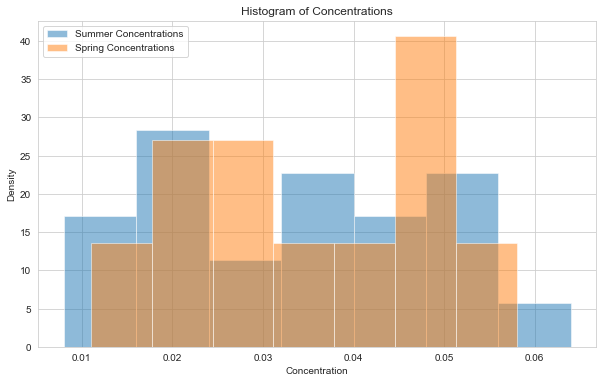

In [71]:
# Plotting the PDFs
plt.figure(figsize=(10, 6))
plt.hist(summer_concentrations, bins=7, density=True, alpha=0.5, label='Summer Concentrations')
plt.hist(spring_concentrations, bins=7, density=True, alpha=0.5, label='Spring Concentrations')
plt.title('Histogram of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

In [72]:
# Calculate CDF for summer concentrations
sorted_summer = np.sort(summer_concentrations)
cdf_summer = np.cumsum(sorted_summer) / np.sum(sorted_summer)

# Calculate CDF for spring concentrations
sorted_spring = np.sort(spring_concentrations)
cdf_spring = np.cumsum(sorted_spring) / np.sum(sorted_spring)

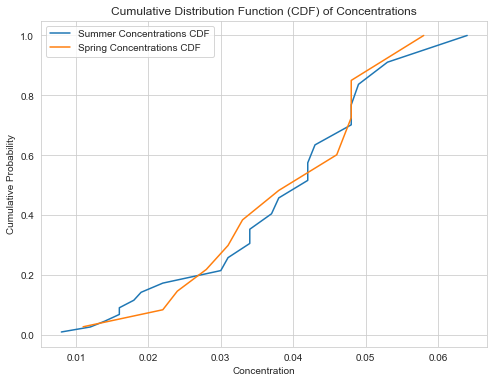

In [73]:
# Plotting the CDFs
plt.figure(figsize=(8, 6))
plt.plot(sorted_summer, cdf_summer, label='Summer Concentrations CDF')
plt.plot(sorted_spring, cdf_spring, label='Spring Concentrations CDF')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

In [ ]:
# Calculate the bin edges
min_concentration = min(summer_concentrations.min(), spring_concentrations.min())
max_concentration = max(summer_concentrations.max(), spring_concentrations.max())
bins = np.linspace(min_concentration, max_concentration, 100)  # 100 bins for example

# Calculate CDF for summer concentrations
hist_summer, bin_edges = np.histogram(summer_concentrations, bins=bins, density=True)
cdf_summer = np.cumsum(hist_summer) * np.diff(bin_edges)

# Calculate CDF for spring concentrations
hist_spring, _ = np.histogram(spring_concentrations, bins=bins, density=True)
cdf_spring = np.cumsum(hist_spring) * np.diff(bin_edges)

# Plotting the CDFs
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[1:], cdf_summer, label='Summer Concentrations CDF')
plt.plot(bin_edges[1:], cdf_spring, label='Spring Concentrations CDF')
plt.title('Cumulative Distribution Function (CDF) of Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()